# Model validation on the Iris dataset

In [2]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
%matplotlib inline

# If you would like to make further imports from tensorflow, add them here
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras import regularizers

## Load and preprocess the data

In [8]:

def read_in_and_split_data(iris_data):
    """
    This function takes the Iris dataset as loaded by sklearn.datasets.load_iris(), and then 
    splits so that the training set includes 90% of the full dataset, with the test set 
    making up the remaining 10%.
    """
    data = iris_data['data']
    targets = iris_data['target']
    
    train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
    
    return (train_data, test_data, train_targets, test_targets)
    
    
    
    

In [9]:

iris_data = datasets.load_iris()
train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

I will now convert the training and test targets using a one hot encoder.

In [10]:

train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

## Build the neural network model


In [11]:
from tensorflow.keras import initializers

In [12]:

def get_model(input_shape):
    """
    This function builds a Sequential model.
    """
    model = Sequential([
        Dense(64,activation = 'relu', kernel_initializer='he_uniform', bias_initializer='ones',input_shape = input_shape),
        Dense(128,activation = 'relu',  ),
        Dense(128,activation = 'relu',  ),
        Dense(128,activation = 'relu',  ),
        Dense(128,activation = 'relu',  ),
        Dense(64,activation = 'relu',  ),
        Dense(64,activation = 'relu',  ),
        Dense(64,activation = 'relu',  ),
        Dense(64,activation = 'relu',  ),
        Dense(3,activation = 'softmax')
    ])
    return model
    

In [17]:
model = get_model(train_data[0].shape)

In [14]:
print(model)

## Compile the model


In [18]:
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    

In [19]:
compile_model(model)

## Fit the model to the training data

In [20]:
def train_model(model, train_data, train_targets, epochs):
    """
    This function trains the model for the given number of epochs on the 
    train_data and train_targets. 
    """
    history = model.fit(train_data,train_targets,epochs=epochs,batch_size = 40, validation_split = 0.15,verbose=False)
    return history
    

In [21]:
history = train_model(model, train_data, train_targets, epochs=800)

## Plot the learning curves

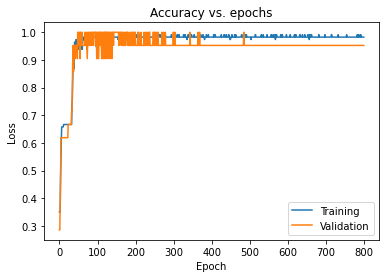

In [22]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

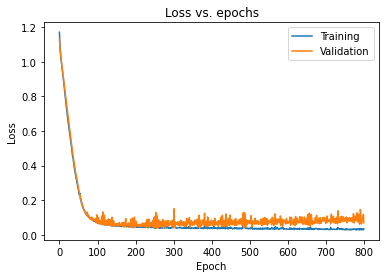

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [44]:
test_loss, test_acc = model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.061
Test accuracy: 100.00%


There's clearly overfitting issues, this will be addressed by using regularization and dropout.

## Reducing overfitting in the model

In [25]:

def get_regularised_model(input_shape, dropout_rate, weight_decay):
    """
    This function builds a regularised Sequential model. 
    """
    model = Sequential([
        Dense(64,activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='he_uniform', bias_initializer='ones',input_shape = input_shape),
        Dropout(dropout_rate),
        Dense(128,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(128,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(128,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(128,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(64,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(64,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(64,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(64,activation = 'relu',kernel_regularizer=regularizers.l2(weight_decay) ),
        Dropout(dropout_rate),
        Dense(3,activation = 'softmax')
    ])
    return model
    
    

#### Instantiate, compile and train the model

In [26]:
reg_model = get_regularised_model(train_data[0].shape, 0.3, 0.001)

In [27]:
compile_model(reg_model)

In [28]:
reg_history = train_model(reg_model, train_data, train_targets, epochs=800)

## Plot the learning curves

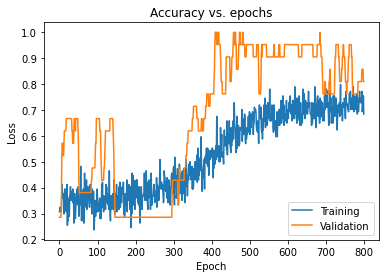

In [29]:
try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

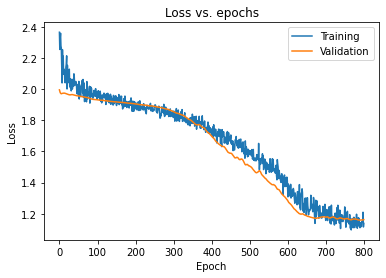

In [31]:
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

We can see that the regularisation has helped to reduce the overfitting of the network.
You will now incorporate callbacks into a new training run that implements early stopping and learning rate reduction on plateaux.

In [32]:
def get_callbacks():
    """
    This function creates and returns a tuple (early_stopping, learning_rate_reduction) callbacks.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min')
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.2)
    
    return early_stopping, lr_reduce
    
    

In [33]:
call_model = get_regularised_model(train_data[0].shape, 0.3, 0.0001)
compile_model(call_model)
early_stopping, learning_rate_reduction = get_callbacks()
call_history = call_model.fit(train_data, train_targets, epochs=800, validation_split=0.15,
                         callbacks=[early_stopping, learning_rate_reduction], verbose=0)

In [34]:
learning_rate_reduction.patience

20

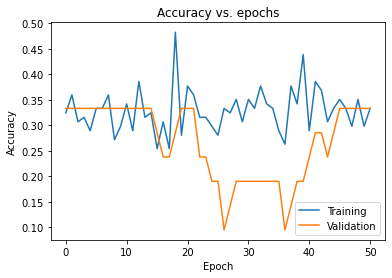

In [35]:
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

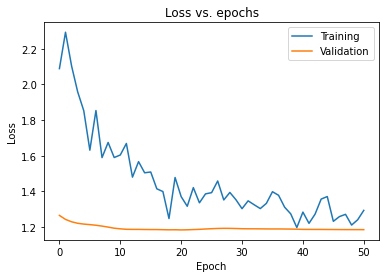

In [36]:
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [40]:
# Evaluate the model on the test set

test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 1.185
Test accuracy: 40.00%
